# Определение стоимости автомобилей

**Условия задачи:**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.  

**Исходные данные:**  
Технические характеристики, комплектации и цены автомобилей.

**Цель работы:**  
Построение, анализ и выбор моделей для определения стоимости. 

**Приоритеты заказчика:**

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
plt.rcParams.update({'font.size': 14})

Откроем файл с данными:

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


В нашем распоряжении 354369 записей. Имеются 16 переменных:  
**Количественные:** *DateCrawled*, *Price* - онo же целевой признак, *RegistrationYear*, *Power*, *Kilometer*, *RegistrationMonth*, *DateCreated*, *NumberOfPictures*, *LastSeen*;  

**Категориальные:** *VehicleType*, *Gearbox*, *Model*, *FuelType*, *Brand*, *NotRepaired*, *PostalCode*.  

В некоторых столбцах имеются пропуски:

In [4]:
df.isna().mean().sort_values(ascending=False).head(6)

NotRepaired    0.200791
VehicleType    0.105794
FuelType       0.092827
Gearbox        0.055967
Model          0.055606
LastSeen       0.000000
dtype: float64

Больше всего данных пропущено в сведениях о ремонте - около 20%. Вполне ожидаемо, поскольку обычно это первый показатель, который пытаются скрыть при продаже подержаного автомобиля. Примерно по 10% пропусков столбцах, касающихся типа кузова и типа топлива. В 5% случаев не указаны тип трансмиссии и модель транспортного средства. Все пропуски только в категориальных признаках.  
Посмотрим на некоторые из них.

In [5]:
df['NotRepaired'].value_counts(dropna=False, normalize=True)

no     0.697468
NaN    0.200791
yes    0.101741
Name: NotRepaired, dtype: float64

Около 70% объявлений пытаются соответствовать сервису "Не бит, не крашен". 20% делают вид, что не заметили вопроса, и всего лишь 10% честно сообщают о том, что автомобиль был в ремонте. В данном случае отсутствие информации - это может само по себе являться информацией. Чтобы наша модель обрабатывала пропуски без ошибок, такие анкеты мы выделим в отдельную категорию "not_reported". 

In [6]:
df['NotRepaired'].fillna('not_reported', inplace=True)

По топливу:

In [7]:
df['FuelType'].value_counts(dropna=False, normalize=True)

petrol      0.610527
gasoline    0.278580
NaN         0.092827
lpg         0.014984
cng         0.001594
hybrid      0.000658
other       0.000576
electric    0.000254
Name: FuelType, dtype: float64

Касаемо типов топлива имеем странную картину. Во-первых, petrol и gasoline - это названия одного и того же бензина. Во-вторых, почему-то отсутствует дизельное топливо, хотя всякие газовые, электрические и гибридные автомобили присутствуют. При наличии записей с дизельным топливом можно было бы petrol и gasoline определить в одну категорию как дубликаты, но есть вероятность, что базе данных petrol, к примеру, это бензин, а gasoline - это обозначение дизельного топлива. Никаких пояснений в ТЗ по этому поводу нет, поэтому оставим как есть. Пропуски можно было бы заменить на бензин, как наиболее популярный вид топлива, но, в силу неясности предоставленных данных, также заменим на значение "not_reported". 

In [8]:
df['FuelType'].fillna('not_reported', inplace=True)

Трансмиссия:

In [9]:
df['Gearbox'].value_counts(dropna=False, normalize=True)

manual    0.756982
auto      0.187051
NaN       0.055967
Name: Gearbox, dtype: float64

Три четверти автомобилей на механике, пятая часть на автомате. Остальные не определились. Коробка передач может быть одной из двух, причём по косвенным признакам это определить сложно - одна и та же модель может быть в двух вариантах. Чтобы не искажать данные, пропуски обрабатывать так же не будем, просто заменим их на категорию "not_reported", чтобы наши модели не пугались. 

In [10]:
df['Gearbox'].fillna('not_reported', inplace=True)

С пропусками осталось два столбца - модель авто и тип кузова. Тип кузова действительно может быть неоднозначным и/или отсутствовать в списке. Этот параметр лучше оставить отдельной категорией. А вот название модели - это с высокой долей вероятности один из определяющих цену параметров и отсутствие значения является недопустимым для оценки стоимости. Такие пропуски мы удалим, порекомендовав разработчикам заставить пользователя эту информацию указывать. 

In [11]:
df['VehicleType'].fillna('unknown', inplace=True)
df.dropna(subset=['Model'], inplace=True)

Пропуски обработаны. 

In [12]:
df['PostalCode'].nunique()

8130

Количество почтовых индексов больше 8 тысяч. Пожалуй, это достаточно бесполезный и даже вредный признак для модели машинного обучения, наравне с датами создания и скачивания анкеты, а также датой последнего визита автора анкеты на сайт. 

Посмотрим на минимальный и максимальный годы регистрации, указанные в анкетах.   

*Стоп. А почему годы регистрации? Может имеется ввиду год выпуска? Год выпуска в базе отсутствует, а вот год и месяц регистрации - эта информация достаточно бестолковая, хотя бы потому что перерегистрировать автомобиль можно много раз. Продолжаю с допущением, что перевод сделан неточно и здесь представлен именно год выпуска.* - прим. автора. 

In [13]:
df['RegistrationYear'].min()

1000

In [14]:
df['RegistrationYear'].max()

9999

Как видим, есть анкеты с некорректно указанным годом выпуска. Посмотрим, сколько таких от общего числа. 

In [15]:
len(df.query('RegistrationYear <= 1886 or RegistrationYear >= 2021')) / len(df)

0.0002868548753376521

Немного. Их можно удалить, а разработчикам сервиса предложить прикрутить фильтр по данному параметру, чтобы пользователь физически не мог указать подобное в заявке на оценку. 

In [16]:
df = df.query('RegistrationYear >= 1886 and RegistrationYear <= 2021')

Посмотрим, как много обычно пользователи оставляют картинок своих авто. 

In [17]:
df['NumberOfPictures'].unique()

array([0])

Во всей базе данных не указано ни одного фото автомобиля. Возможные причины: никто не загружает фоток (маловероятно, если сервис это позволяет делать), ошибка на сервере (счётчик не работает) или ошибка выгрузки. В любом случае данный столбец для обучения не годится (лишние погрешности, лишняя нагрузка на железо). 

In [18]:
df['RegistrationMonth'].unique()

array([ 0,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9])

Встречается нулевой месяц регистрации. Видимо авторы таких анкет - программисты, или просто они не знают (не хотят знать, лень посмотреть в ПТС и т.д.), т.е. по факту указывают только год выпуска. 

In [19]:
len(df[df['RegistrationMonth'] == 0]) / len(df)

0.09188266660290285

Таких записей около 10%. Удалять или как-то корректировать их не будем. Пусть остаются отдельной категорией.

In [20]:
len(df[df['Price'] == 0]) / len(df)

0.025639033021687668

Среди целевого признака в 3% случаях цена автомобиля указана нулевой. Теоретически такое возможно, например в случае "Заберите уже кто-нибудь у меня этот разбитый вдребезги хлам!". Но чаще всего даже такие автомобили пытаются сдать на запчасти. Вероятнее всего, владельцы, не указавшие цену, либо сами не представляют её, либо обозначают таким образом возможность открытого торга. А может быть это и ошибки при обработке. Но раз мы хотим получить максимально объективный сервис по быстрой оценке, то от таких значений лучше избавиться. 

In [21]:
df = df[df['Price'] != 0]

С мощностью двигателя тоже какой-то бардак.

In [22]:
len(df[df['Power'] == 0]) / len(df)

0.09592625540660757

Во-первых, в 10% анкет она равна нулю. Такое может быть только если двигателя нет, но в этом случае это уже не автомобиль, а телега, а по условию задачи мы работаем с сервисом по продаже автомобилей. Впрочем, вероятнее всего это просто человеческий фактор - владелец анкеты не указал. Не будем ничего с этим делать, оставим на совести пользователей.

In [23]:
len(df[df['Power'] >= 1000]) / len(df)

0.0007730298475413357

In [24]:
df[df['Power'] >= 1000].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,not_reported,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,not_reported,2016-04-02 00:00:00,0,65830,2016-04-06 11:46:49
9664,2016-03-14 20:06:19,2599,unknown,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27
9875,2016-03-31 20:51:13,550,wagon,2003,manual,1753,focus,150000,1,gasoline,ford,yes,2016-03-31 00:00:00,0,21039,2016-03-31 20:51:13


Во-вторых, имеются записи, где мощность двигателя более 1000 л.с., что так же маловероятно. Причём, некоторые в это графу пишут не мощность двигателя, а его объем. Иные просто вносят какие-то неадекватные цифры. 

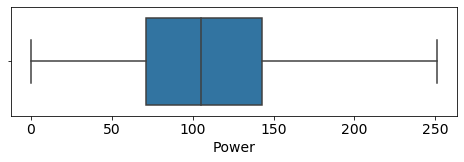

In [25]:
plt.figure(figsize=(8,2))
sns.boxplot(x=df['Power'], showfliers=False)
plt.show()

В целом почти все автомобили имеют мощность до 250 л.с. остальное можно считать выбросами. Хотя некоторые экзепмпляры действительно обладают мощными двигателями (те же грузовики). Так что разумнее ограничить верхний предел 500 л.с., а остальное из датасета убрать. 

In [26]:
df = df[df['Power'] <= 500]

Посмотрим, есть ли полные дубликаты?

In [27]:
df.duplicated().sum()

4

Есть. Их тоже удалим. 

In [28]:
df = df.drop_duplicates()

**Выводы:**


- В данных имелись пропущенные значения. Только в категориальных признаках. Обработано. 
- Часть данных из датасета удалена - дубликаты, анкеты с целевым признаком равным нулю, некорректные данные по мощности и году выпуска. 
- Не совсем понятная ситуация с имеющимися в базе типами топлива - есть два названия бензина, но отсутствует дизельное топливо, требуется уточнение у поставщика данных.
- Не все колонки годятся в качестве признаков. 
- Рекомендации разработчикам:  
1) Дописать фильтр по году выпуска автомобиля во избежании ввода некорректных значений;  
2) Проверить правильность обработки выгрузки данных (во всех записях количество фотографий равно нулю). 
- Данные подготовлены к обучению моделей. 

## Обучение моделей

Сначала рассмотрим два алгоритма градиентного бустинга - LightGBM и CatBoost, затем попробуем более простые алгоритмы - решающее дерево и случайный лес. Качество моделей будем оценивать метрикой RMSE.

### Формирование выборок

Разделим основной датасет на три выборки - тренировочную, валидационную и тестовую в соотношении 3:1:1. На тренировочной будем выполнять обучение, на валидационной выполнять оценку, в конце проверим результат на тестовой выборке. 

In [29]:
features_list = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 
                 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']
target_list = ['Price']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

features_train, features_valid, target_train, target_valid = \
train_test_split(df[features_list], df[target_list], test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

In [30]:
print(len(df))
len(features_train) + len(features_valid) + len(features_test)

325614


325614

Готово.

### Catboost

Первым рассмотрим алгоритм градиентного бустинга Catboost. Его особенностью является возможность работы с категориальными признаками напрямую. Этим и воспользуемся. Так же будем использовать наш валидационный датасет для предотвращения переобучения модели. Максимальное количество деревьев по умолчанию стоит 1000 - оставим эту величину, а скорость обучения подберём такую, чтобы задача сходилась близко к этому значению итераций. 

In [31]:
%%time
cb_model = CatBoostRegressor(learning_rate=0.4,
                             early_stopping_rounds=20, 
                             random_state=42, 
                             one_hot_max_size=300)
cb_model.fit(features_train, target_train, cat_features=cat_features, 
               eval_set=(features_valid, target_valid), verbose=100)

0:	learn: 3451.1910284	test: 3463.4830366	best: 3463.4830366 (0)	total: 75.6ms	remaining: 1m 15s
100:	learn: 1656.4059614	test: 1719.3331865	best: 1719.3331865 (100)	total: 9.62s	remaining: 1m 25s
200:	learn: 1572.4080163	test: 1660.7484224	best: 1660.7484224 (200)	total: 19.1s	remaining: 1m 15s
300:	learn: 1522.9804312	test: 1634.7798684	best: 1634.7798684 (300)	total: 28.5s	remaining: 1m 6s
400:	learn: 1489.3148248	test: 1621.9003908	best: 1621.6790399 (399)	total: 37.9s	remaining: 56.5s
500:	learn: 1461.1285571	test: 1610.3106096	best: 1610.2838130 (497)	total: 47.3s	remaining: 47.1s
600:	learn: 1438.3818811	test: 1605.6615749	best: 1605.6560083 (599)	total: 56.8s	remaining: 37.7s
700:	learn: 1417.1777869	test: 1599.2298440	best: 1599.1686483 (699)	total: 1m 6s	remaining: 28.4s
800:	learn: 1400.1183108	test: 1594.0552350	best: 1594.0552350 (800)	total: 1m 16s	remaining: 18.9s
900:	learn: 1384.4911077	test: 1590.5302918	best: 1590.5185704 (896)	total: 1m 25s	remaining: 9.45s
Stopped 

Задача обучения сошлась на 965 итерациях. Время выполнения составило 1 минуту 35 секунд. (*может меняться в зависимости от времени суток и степени загрузки сервера - прим. автора*)

In [32]:
cb_model.best_score_

{'learn': {'RMSE': 1371.9867986690429},
 'validation': {'RMSE': 1587.8557177495416}}

Получили RMSE на обучающей выборке 1372, а на валидационной 1588. Сохраним эти значения. 

In [33]:
cb_train_score = cb_model.best_score_['learn']['RMSE']
cb_valid_score = cb_model.best_score_['validation']['RMSE']
cb_train_time = 95

In [34]:
%%time
cb_test_result = cb_model.predict(features_test)

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 165 ms


Скорость предсказания примерно 250 мс. 

In [35]:
cb_predict_time = 0.25
cb_test_score = mean_squared_error(target_test, cb_test_result) ** 0.5
cb_test_score

1560.185823095329

На тестовой выборке RMSE = 1560.

### Кодирование признаков

Другие алгоритмы не столь всеядны и для них требуется выполнить кодирование категориальных перменных. Чтобы не увеличивать количество столбцов, воспользуемся техникой порядкового кодирования. 

In [36]:
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_features])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [37]:
features_train[cat_features] = encoder.transform(features_train[cat_features])
features_valid[cat_features] = encoder.transform(features_valid[cat_features])
features_test[cat_features] = encoder.transform(features_test[cat_features])

In [38]:
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
200443,5.0,1997,1.0,50,173.0,150000,10,7.0,37.0,0.0
204162,4.0,1996,0.0,122,59.0,150000,0,7.0,20.0,0.0
193087,8.0,2007,1.0,177,44.0,125000,8,2.0,35.0,0.0
278344,8.0,2011,1.0,105,116.0,80000,7,2.0,37.0,0.0
274005,0.0,2000,1.0,151,224.0,150000,12,2.0,37.0,0.0


Кодирование выполнено.

### LightGBM

Теперь обучим модель LightGBM. Чтобы у двух рассмотренных моделей был хоть какой-то общий знаменатель для сравнения, максимальное количество деревьев установим 1000, и скорость обучения подберём по аналогии с Catboost, чтобы задача сошлась ближе к концу. 

In [39]:
%%time

train_dataset = lgb.Dataset(features_train, target_train, categorical_feature=cat_features)
valid_dataset = lgb.Dataset(features_valid, target_valid, categorical_feature=cat_features)

params = {"objective": "regression",
          "metric":'rmse',
          "learning_rate":0.2,
          "seed":42}

lgbm_model = lgb.train(params=params, 
                       train_set=train_dataset, 
                       valid_sets=(train_dataset, valid_dataset),
                       num_boost_round=1000, 
                       verbose_eval=100,
                       early_stopping_rounds = 50
                      )

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1530.85	valid_1's rmse: 1638.78
[200]	training's rmse: 1453.49	valid_1's rmse: 1608.15
[300]	training's rmse: 1406.27	valid_1's rmse: 1596.84
[400]	training's rmse: 1368.92	valid_1's rmse: 1587.57
[500]	training's rmse: 1340.82	valid_1's rmse: 1584.19
[600]	training's rmse: 1312.27	valid_1's rmse: 1579.98
[700]	training's rmse: 1288.22	valid_1's rmse: 1576.21
[800]	training's rmse: 1268.28	valid_1's rmse: 1574.34
[900]	training's rmse: 1251.38	valid_1's rmse: 1573.34
Early stopping, best iteration is:
[891]	training's rmse: 1252.65	valid_1's rmse: 1572.92
CPU times: user 34 s, sys: 0 ns, total: 34 s
Wall time: 34.6 s


При заданных гиперпараметрах алгоритму LightGBM потребовалась менее 40 секунд, чтобы выполнить 891 итерацию и получить RMSE = 1252 на трейне и RMSE = 1573 на валидации. 

Сохраним результат. 

In [40]:
lgbm_train_score = mean_squared_error(target_train, lgbm_model.predict(features_train)) ** 0.5
lgbm_valid_score = mean_squared_error(target_valid, lgbm_model.predict(features_valid)) ** 0.5
lgbm_train_time = 38.5

Оценим время предсказания. 

In [41]:
%%time

lgbm_test_result = lgbm_model.predict(features_test)

CPU times: user 4.56 s, sys: 0 ns, total: 4.56 s
Wall time: 4.58 s


Около 4.5 секунд. 

In [42]:
lgbm_predict_time = 4.59
lgbm_test_score = mean_squared_error(target_test, lgbm_test_result) ** 0.5
lgbm_test_score

1538.152238483256

На тестовой выборке RMSE = 1538.

### Более простые модели

Выполним оценку по более простым моделям - решающему дереву и случайному лесу. 

In [43]:
model = DecisionTreeRegressor(random_state=42)

tree_params = {
    'max_depth':[x for x in range(1, 50, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = RandomizedSearchCV(model, tree_params, 
                               scoring='neg_mean_squared_error', 
                               n_iter=20, random_state=45, cv=5)
tree_grid.fit(features_train, target_train)

tree_model = DecisionTreeRegressor(random_state=42, **tree_grid.best_params_)

In [44]:
%%time
tree_model.fit(features_train, target_train)

CPU times: user 633 ms, sys: 0 ns, total: 633 ms
Wall time: 642 ms


DecisionTreeRegressor(criterion='mse', max_depth=27, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

С уже подобранными гиперпараметрами модель обучается буквально за полсекунды. 

In [45]:
%%time
tree_test_result = tree_model.predict(features_test)

CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 17.1 ms


Да и предсказывает практически мгновенно. Осталось увидеть, что она нам предсказывает. 

In [46]:
tree_train_time = 0.667
tree_predict_time = 0.017
tree_train_score = mean_squared_error(target_train, tree_model.predict(features_train)) ** 0.5
tree_valid_score = mean_squared_error(target_valid, tree_model.predict(features_valid)) ** 0.5
tree_test_score = mean_squared_error(target_test, tree_model.predict(features_test)) ** 0.5
print('train RMSE =', tree_train_score)
print('valid RMSE =', tree_valid_score)
print('test RMSE =', tree_test_score)

train RMSE = 1533.4800301255066
valid RMSE = 1856.1946886338826
test RMSE = 1816.6214250783842


Результат заметно хуже бустинговых моделей. Быть может случайный лес даст лучший результат?

In [47]:
%%time
# Около 2 минут

model = RandomForestRegressor(random_state=42)

#Сетка поиска сокращена для экономии времени
forest_params = {
    'n_estimators':[x for x in range(50, 51, 1)],
    'max_depth':[x for x in range(18, 19, 1)], 
    'min_samples_leaf':[x for x in range(5, 6, 1)],
    'min_samples_split':[x for x in range(3, 4, 1)],
}

forest_grid = RandomizedSearchCV(model, forest_params, 
                                 scoring='neg_mean_squared_error', 
                                 n_iter=1, random_state=42, cv=5)
forest_grid.fit(features_train, np.ravel(target_train))

forest_model = RandomForestRegressor(random_state=42, **forest_grid.best_params_)

CPU times: user 1min 43s, sys: 0 ns, total: 1min 43s
Wall time: 1min 43s


In [48]:
%%time
forest_model.fit(features_train, np.ravel(target_train))

CPU times: user 20.4 s, sys: 0 ns, total: 20.4 s
Wall time: 20.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Подбор гиперпараметров для алгоритма случайного леса занимает много времени. Модель с выбранными параметрами в нашем случае обучается чуть дольше 30 секунд. 

In [49]:
%%time
tree_test_result = tree_model.predict(features_test)

CPU times: user 18.1 ms, sys: 0 ns, total: 18.1 ms
Wall time: 16.7 ms


Предсказание результата осуществляется за несколько милисекунд. 

In [50]:
forest_train_time = 34
forest_predict_time = 0.02
forest_train_score = mean_squared_error(target_train, forest_model.predict(features_train)) ** 0.5
forest_valid_score = mean_squared_error(target_valid, forest_model.predict(features_valid)) ** 0.5
forest_test_score = mean_squared_error(target_test, forest_model.predict(features_test)) ** 0.5
print('train RMSE =', forest_train_score)
print('valid RMSE =', forest_valid_score)
print('test RMSE =', forest_test_score)

train RMSE = 1330.0036011547948
valid RMSE = 1684.0391017679228
test RMSE = 1643.1879201361844


Точность прогноза средняя. 

## Анализ моделей

Сформирует сводную таблицу с достигнутыми результатами. 

In [51]:
data = [
    [cb_train_score, cb_valid_score, cb_test_score, cb_train_time, cb_predict_time],
    [lgbm_train_score, lgbm_valid_score, lgbm_test_score, lgbm_train_time, lgbm_predict_time],
    [forest_train_score, forest_valid_score, forest_test_score, forest_train_time, forest_predict_time],
    [tree_train_score, tree_valid_score, tree_test_score, tree_train_time, tree_predict_time]
       ]
     
index = ['Catboost','LightGBM', 'RandomForest', 'RandomTree']
columns = ['Train_RMSE', 'Valid_RMSE', 'Test_RMSE', 'Train_Time[s]', 'Predict_Time[s]']
final = pd.DataFrame(data, index=index, columns=columns)
final

,Train_RMSE,Valid_RMSE,Test_RMSE,Train_Time[s],Predict_Time[s]
Catboost,1371.986799,1587.855718,1560.185823,95.000,0.250
LightGBM,1252.649077,1572.923173,1538.152238,38.500,4.590
RandomForest,1330.003601,1684.039102,1643.187920,34.000,0.020
RandomTree,1533.480030,1856.194689,1816.621425,0.667,0.017


Для более наглядного сравнения посмотрим на диаграммы.

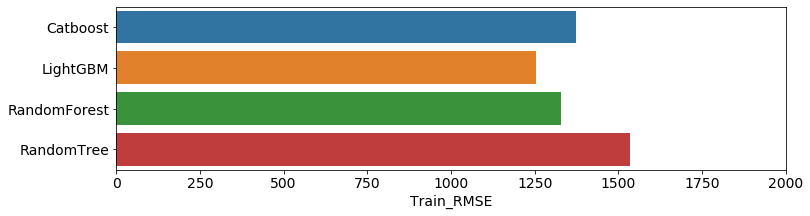

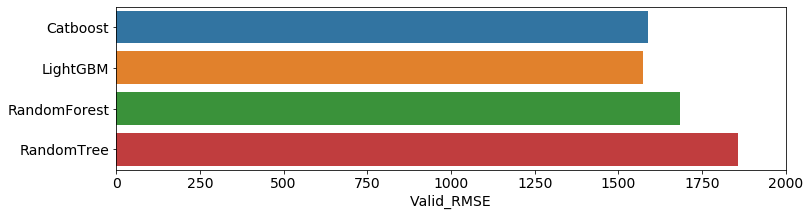

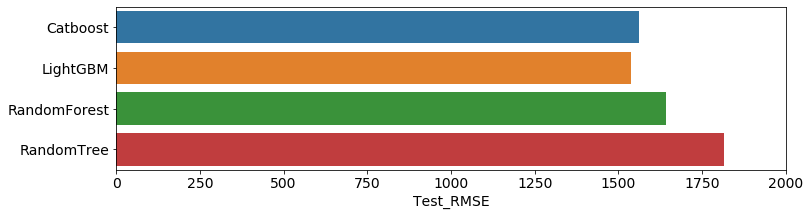

In [52]:
for col in columns[:3]:
    plt.figure(figsize=(12, 3))
    sns.barplot(y=index, x=col, data=final)
    plt.xlim(0,2000)
    plt.show()

Наибольшей точностью прогноза обладает алгоритм LGBM, модель Catboost отстаёт не сильно. Хуже всего модель случайного дерева, а лес где-то посреди. Посмотрим, как эти результаты соотносятся с константной моделью. 

In [53]:
df['Price'].mean()

4622.993624352761

In [54]:
mean_squared_error(target_test['Price'], 
                   pd.Series(target_train['Price'].mean(), 
                   index=target_test.index)) ** 0.5

4521.236842207682

При средней цене подержаных авто в 4600 евро, точность прогноза всех моделей 35-40% от этой величины. Насколько это удовлетворительно по исходным данным судить сложно. Но все модели работают значительно лучше константной модели и это хорошо.  
Оценим время работы. 

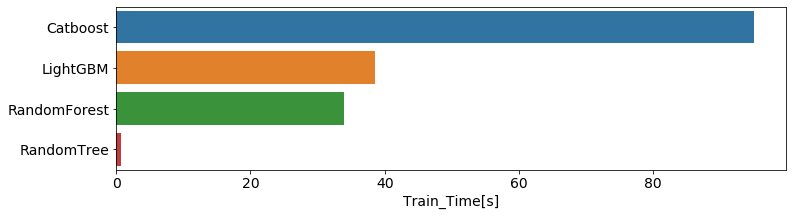

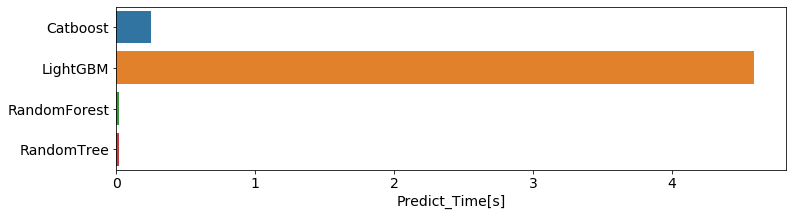

In [55]:
for col in columns[3:]:
    plt.figure(figsize=(12, 3))
    sns.barplot(y=index, x=col, data=final)
    plt.show()

Обучение моделей при условии уже выбранных гиперпараметров может занимать значительное время, особенно если искать варианты с наиболее точным предсказанием. В текущей работе рассмотрены модели с адекватным временем обучения в примерно одинаковых условиях. Наибольшее время обучения занимает у модели градиентного бустинга Catboost. LGBM и случайный лес обучаются вдвое быстрее. А одинокое дерево - практически мгновенно. Скорость предсказания у леса и дерева максимальная - несколько милисекунд, Кэтбуст справляется за четверть секунды, а вот LGBM предсказывает результат на порядок дольше - несколько секунд. 

## Заключение

На основании исходных данных выполнено построение четырёх моделей машинного обучения для быстрой предварительной оценки подержаных автомобилей в интересах сервиса "Не бит, не крашен".  

Достигнутые результаты показывают, что наибольшей точностью предсказания обладают алгоритмы градиентного бустинга LightGBM и Catboost, RMSE = 1538 и 1560 соответственно, но при схожих настройках LightGBM обучается вдвое быстрее, хотя время предсказания у него достаточно долгое - на имеющейся тестовой выборке более 4 секунд, что может быть критичным для нормальной работы приложения. Catboost хоть и обучается дольше, но предсказание выполняет за четверть секунды при близком значении качества. 

Из более простых моделей неплохо показал себя алгоритм случайного леса. Скорость обучения наравне с LGBM, но скорость предсказания почти моментальная. Финальное RMSE = 1640, что несколько хуже бустинговых моделей. Алгоритм случайного дерева обучается быстрее всех и предсказывает быстрее всех, но и RMSE = 1816, что является наихудшим результатом. 

Таким образом, если приоритет Заказчика в первую очередь направлен на качество предсказания, и он обладает достаточными вычислительными ресурсами для обработки большого количество запросов на оценку, то ему стоит обратить внимание на модель с алгоритмом LightGBM. Если же Заказчику важен баланс между качестом/скоростью предсказаний и есть время/ресурсы на длительное обучение модели, то вполне подойдёт Catboost. Если же приоритет сместить в сторону быстродействия, не взирая на качество предсказания, то можно обойтись и простыми деревьями или их ансамблем. 

В случае возникновения дополнительных условий или новых входных данных, наша команда готова продолжать работы согласно установленного прайс-листа. 